# eCommerce Predict Repurchase 

In this project, I utilized data from an eCommerce platform __[link](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)__ to predict repurchase. The project comprises four main parts:

Part 1 - Data Exploration: This involves visualization and quality checks of the data.

Part 2 - ETL (Extract, Transform, Load): Tasks include creating a Postgres database, feature engineering, and loading data for modeling in SQL.

Part 3 - Data Preprocessing and Modeling: Utilizing techniques such as XGBoost and Random Forest to preprocess the data and build predictive models.

Part 4 - Business Recommendations: Providing actionable insights and recommendations based on the analysis and modeling results.



# Part 1



## 1. Load Data 

In [10]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# read all csv dataset
aisles = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\aisles.csv')
departments = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\departments.csv')
order_products_prior = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\order_products_prior.csv')
order_products_train = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\order_products_train.csv')
orders = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\orders.csv')
products = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\products.csv')


In [12]:
# check data dimension 
print(aisles.shape)
print(departments.shape)
print(order_products_prior.shape)
print(order_products_train.shape)
print(orders.shape)
print(products.shape)

(134, 2)
(21, 2)
(793924, 4)
(53704, 4)
(82683, 7)
(49688, 4)



## 2. EDA 

In [13]:
orders.head() # eval_set(prior), days_since_prior_order
order_products_prior.head() # reordered (1 & 0)
# inner join orders and order_products_prior
order_prior_join = order_products_prior.merge(orders, on = 'order_id')

# check unique value of 'eval_set'
order_prior_join['eval_set'].unique() # only one unique value - 'prior'
order_prior_join['eval_set'].isna().sum() # no null, so every order in order_products_prior is prior purchasing

# inner join order_prior_join, products and departments
order_prior_department_join = order_prior_join.merge(products, on = 'product_id')
order_prior_department_join = order_prior_department_join.merge(departments, on = 'department_id')
order_prior_department_join.head()

# convert days from number into word
#order_prior_department_join["order_dow"] = order_prior_department_join["order_dow"].apply(lambda x:"Sunday" if x==0 else x)

# create a dictionary to map number to day names
day_mapping = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}

# Apply the mapping to the 'order_dow' column
order_prior_department_join['order_dow'] = order_prior_department_join['order_dow'].map(day_mapping)

In [14]:
order_prior_join['eval_set'].unique()

array(['prior'], dtype=object)

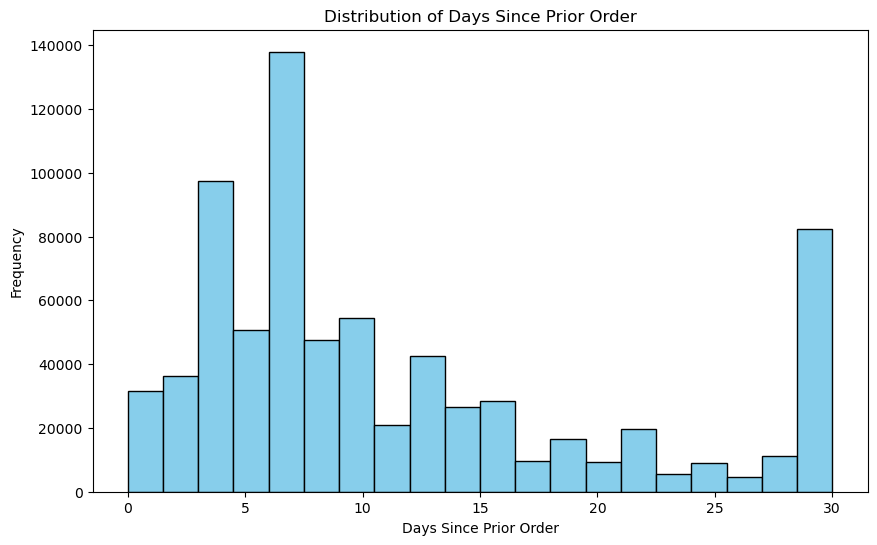

In [15]:
# Plot the distribution of Days Since Prior Order 
plt.figure(figsize=(10, 6))
plt.hist(order_prior_department_join['days_since_prior_order'], bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Days Since Prior Order')
plt.ylabel('Frequency')
plt.title('Distribution of Days Since Prior Order')

plt.show()

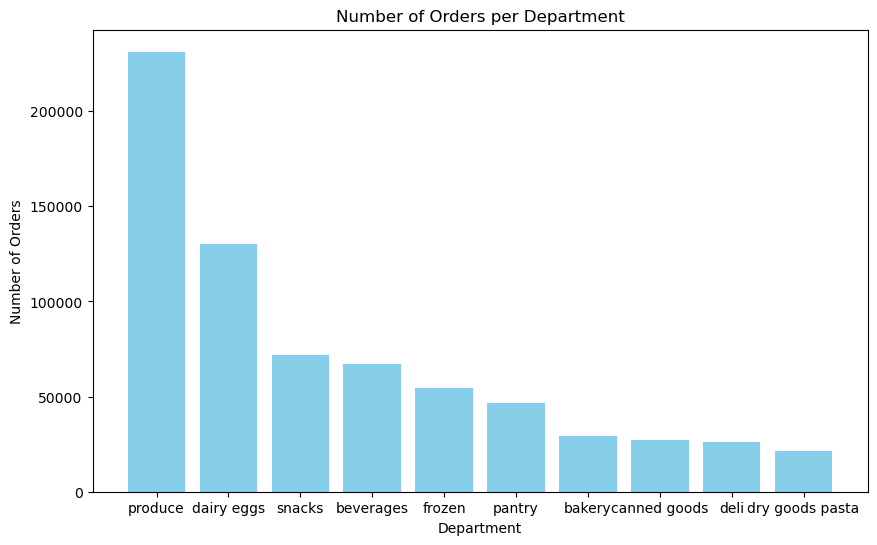

In [16]:
# orders for each departments - bar chart
# count order id for each department, sort_value, and plot top 10 department
order_department_count = order_prior_department_join.groupby('department')['order_id'].count().sort_values(ascending=False).head(10).reset_index()

# Plot the bar chart 
plt.figure(figsize=(10, 6))  # Enlarge the figure
plt.bar(order_department_count['department'], order_department_count['order_id'], color='skyblue')

plt.xlabel('Department')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Department')

plt.show()

In [17]:
order_prior_department_join

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department
0,12,30597,1,1,152610,prior,22,Saturday,8,10.0,French Vanilla Coffee Creamer,53,16,dairy eggs
1,29292,30597,7,1,112604,prior,15,Wednesday,10,1.0,French Vanilla Coffee Creamer,53,16,dairy eggs
2,50422,30597,41,0,75304,prior,28,Tuesday,8,12.0,French Vanilla Coffee Creamer,53,16,dairy eggs
3,94545,30597,4,1,22499,prior,20,Thursday,9,30.0,French Vanilla Coffee Creamer,53,16,dairy eggs
4,138033,30597,3,0,152610,prior,2,Thursday,13,13.0,French Vanilla Coffee Creamer,53,16,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793919,3367009,27450,14,0,142566,prior,63,Friday,12,4.0,Mushroom,100,21,missing
793920,3388158,2608,5,0,155161,prior,4,Saturday,14,8.0,Taste Of Asia Tonkotsu Pork,100,21,missing
793921,3388158,25663,6,0,155161,prior,4,Saturday,14,8.0,Taste Of Asia Spicy Miso Chicken,100,21,missing
793922,3388158,35710,7,0,155161,prior,4,Saturday,14,8.0,Taste Of Asia Sukiyaki Beef,100,21,missing


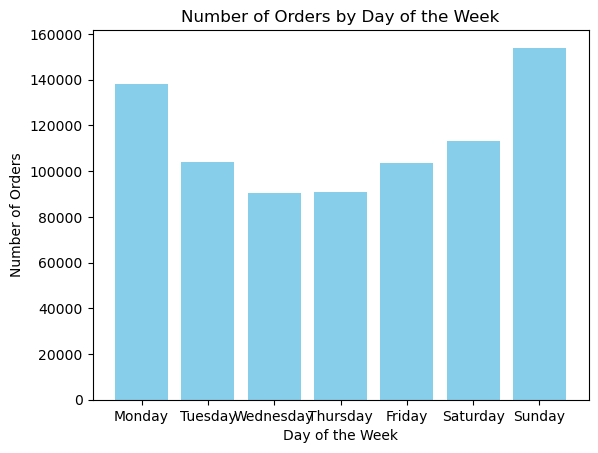

In [18]:
# orders for each day - bar chart
order_dow_count = order_prior_department_join.groupby('order_dow')['order_id'].count().reset_index()

# Define the order of days
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Reorder the DataFrame according to the desired day order ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
order_dow_count['order_dow'] = pd.Categorical(order_dow_count['order_dow'], categories=day_order, ordered=True)
order_dow_count = order_dow_count.sort_values('order_dow')

# Plot bar chart 
plt.bar(order_dow_count['order_dow'], order_dow_count['order_id'], color='skyblue')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by Day of the Week')

plt.show()


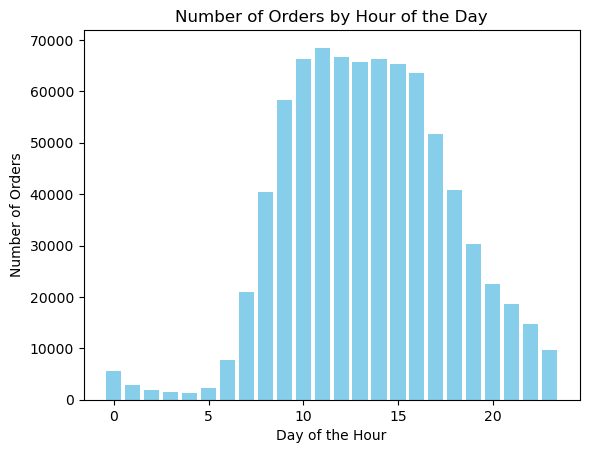

In [19]:
# Count orders each hour
order_doh_count = order_prior_department_join.groupby('order_hour_of_day')['order_id'].count().reset_index()
order_doh_count
# Plot the bar chart 
plt.bar(order_doh_count['order_hour_of_day'], order_doh_count['order_id'], color='skyblue')

plt.xlabel('Day of the Hour')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by Hour of the Day')

plt.show()

In [28]:
reorder_heatmap = order_prior_department_join.groupby(["order_dow", "order_hour_of_day"])["reordered"].mean().reset_index()
reorder_heatmap
#reorder_heatmap.columns

,order_dow,order_hour_of_day,reordered
0,Friday,0,0.567251
1,Friday,1,0.572034
2,Friday,2,0.550388
3,Friday,3,0.535354
4,Friday,4,0.496183
...,...,...,...
163,Wednesday,19,0.596164
164,Wednesday,20,0.578599
165,Wednesday,21,0.540113
166,Wednesday,22,0.573974


In [27]:
reorder_heatmap1 = reorder_heatmap.pivot('order_dow', 'order_hour_of_day', 'reordered')
reorder_heatmap1

C:\Users\shenl\AppData\Local\Temp\ipykernel_8540\4118443761.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  reorder_heatmap1 = reorder_heatmap.pivot('order_dow', 'order_hour_of_day', 'reordered')


order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
Friday,0.567251,0.572034,0.550388,0.535354,0.496183,0.630058,0.680883,0.634418,0.610677,0.622049,...,0.574965,0.596886,0.566166,0.592004,0.589528,0.584020,0.627149,0.587676,0.575840,0.560068
Monday,0.599442,0.591837,0.617251,0.572581,0.674641,0.622010,0.676249,0.660356,0.660913,0.630201,...,0.587335,0.599543,0.596117,0.567598,0.573962,0.580768,0.555831,0.555922,0.547170,0.565366
Saturday,0.438291,0.522852,0.582677,0.546099,0.404908,0.639640,0.637555,0.663746,0.600063,0.610521,...,0.566792,0.556966,0.548146,0.552816,0.551941,0.621935,0.563981,0.559144,0.604764,0.608067
Sunday,0.596118,0.492063,0.519417,0.487805,0.635659,0.561798,0.628070,0.625713,0.632673,0.580712,...,0.547221,0.587734,0.563119,0.560964,0.579957,0.565647,0.610511,0.563980,0.573087,0.565396
Thursday,0.558081,0.590258,0.472973,0.570136,0.496124,0.637821,0.638517,0.643494,0.609187,0.604442,...,0.582064,0.573727,0.595724,0.614588,0.601024,0.576763,0.546398,0.571263,0.598508,0.543887
Tuesday,0.564184,0.633690,0.655172,0.613333,0.494382,0.651709,0.614837,0.650794,0.625297,0.619295,...,0.574408,0.573125,0.575652,0.564880,0.559078,0.566420,0.575627,0.583224,0.514218,0.541526
Wednesday,0.538576,0.431373,0.433333,0.661616,0.601307,0.632353,0.640719,0.607026,0.647715,0.612631,...,0.567920,0.594027,0.556999,0.574547,0.568327,0.596164,0.578599,0.540113,0.573974,0.557210


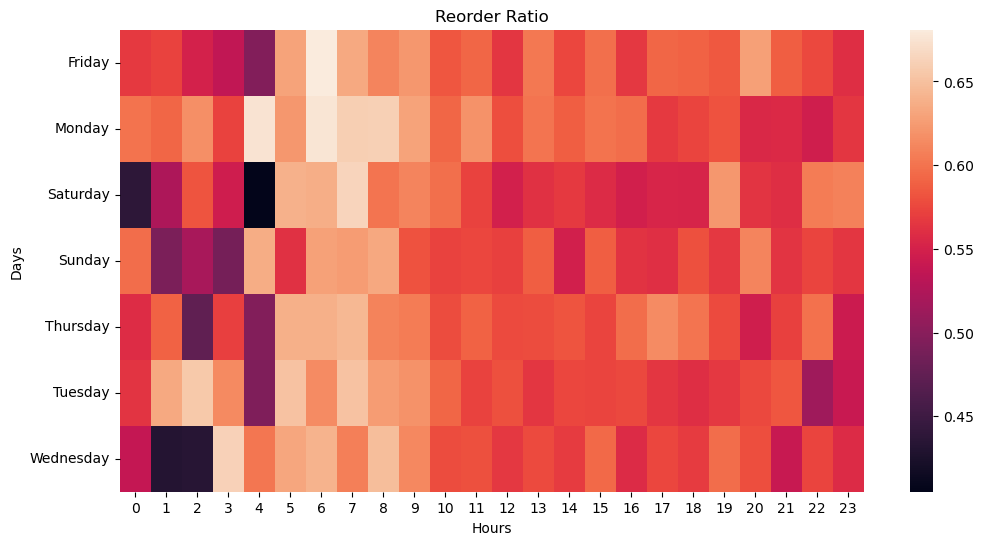

In [31]:
# heatmap
plt.figure(figsize=(12,6))
sns.heatmap(reorder_heatmap1)
plt.title("Reorder Ratio")
plt.ylabel("Days")
plt.xlabel("Hours")
plt.show()

## 3. Explore and Check Data Quality

In [12]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0
...,...,...,...,...,...,...,...
82678,960985,206175,prior,3,0,14,8.0
82679,583707,206175,prior,4,1,17,30.0
82680,2950302,206175,prior,5,0,14,6.0
82681,398664,206175,prior,6,0,9,14.0


In [13]:
# check orders dataset 
orders['eval_set'].unique() # orders include both ['prior', 'train']

# count #orders from prior and train
unique_order = orders.drop_duplicates()

# check # orders for prior and train: prior 77683, train 5000
count_order_prior_train = unique_order.groupby('eval_set')['order_id'].count().reset_index()

In [14]:
# 5000 nulls from 'days_since_prior_order' due to 5000 first time order
# number of orders that was first order = 5000
sum(unique_order['order_number'] == 1)
# number of null from 'days_since_prior_order' = 5000
sum(unique_order['days_since_prior_order'].isna())
# total number of user_id = 5000
unique_order['user_id'].nunique()

5000

In [15]:
# there are 5000 user_id for both prior and train
count_user_prior_train = unique_order.groupby('eval_set')['user_id'].nunique().reset_index()
#unique_order['user_id'][unique_order['eval_set'] == 'prior'].unique()
user_prior_set = set(unique_order['user_id'][unique_order['eval_set'] == 'prior'])
user_train_set = set(unique_order['user_id'][unique_order['eval_set'] == 'train'])

# check whether orders dataset share the same user_id between train and prior
len(user_prior_set.intersection(user_train_set)) # use shape for numpy or pandas, use len for sets
# both train and prior contains the same 5000 user_id

5000

There are (same) 5000 user_id for train and prior.

train include 5000 first time order?
in orders dataset, it contains prior 77683, train 5000
in order_products_prior, it contains 77683 orders which are in orders dataset
in order_products_train, it contains 5000 orders which are in orders dataset
order_products_prior has different orders from order_products_train

In [17]:
# check order_products_prior and order_products_train
unique_order_prior = order_products_prior.drop_duplicates()
unique_order_prior['order_id'].nunique() #77683 prior orders (include the first time orders), match from orders dataset
order_prior_set = set(unique_order_prior['order_id'])

unique_order_train = order_products_train.drop_duplicates()
unique_order_train['order_id'].nunique() #5000 first time orders, match from orders dataset
order_train_set = set(unique_order_train['order_id'])

# orders in 'order_products_train' are not in 'order_products_prior'
len(order_prior_set.intersection(order_train_set)) #0

# order_id found in 'order_products_prior' are in 'orders'
unique_order_prior[unique_order_prior['order_id'].isin(unique_order['order_id'])] # transcetional data

# order_id found in 'order_products_train' are in 'orders'
unique_order_train[unique_order_train['order_id'].isin(unique_order['order_id'])] # transcetional data

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1
...,...,...,...,...
53699,3420996,2086,7,1
53700,3420996,29118,8,0
53701,3420996,27423,9,1
53702,3420996,12125,10,1


In [74]:
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0
...,...,...,...,...
793919,3421029,29418,7,0
793920,3421029,40449,8,1
793921,3421029,37687,9,1
793922,3421029,13852,10,0


In [21]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0
...,...,...,...,...,...,...,...
82678,960985,206175,prior,3,0,14,8.0
82679,583707,206175,prior,4,1,17,30.0
82680,2950302,206175,prior,5,0,14,6.0
82681,398664,206175,prior,6,0,9,14.0
